# Extreme Learning Machine

## Fast gradient method

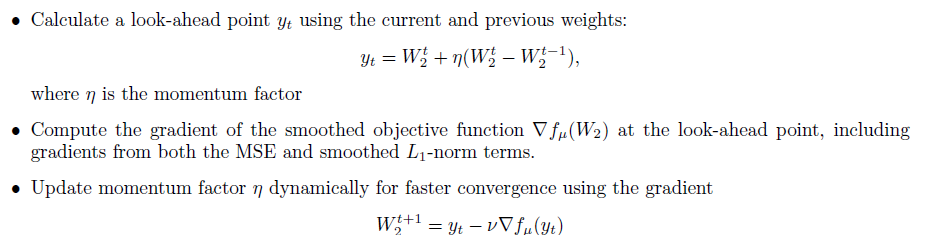

## 1) ELM implementation

In [17]:
import numpy as np

class ELM:
    def __init__(self, input_size, hidden_size, output_size, activation='relu', seed=None):
        """
        Initializes the ELM with a fixed random input->hidden layer (W1, b1)
        and trainable hidden->output layer (W2, b2). 
        """
        if seed:
            np.random.seed(seed)
        # Input -> Hidden layer
        self.W1 = np.random.randn(hidden_size, input_size)
        self.b1 = np.random.randn(hidden_size, 1)
        # Hidden -> Output layer (trainable)
        self.W2 = np.random.randn(output_size, hidden_size)
        self.b2 = np.random.randn(output_size, 1)
        
        self.activation = activation

    def _activation(self, x):
        """
        Applies the elementwise activation function.
        Currently supports only ReLU, as per the references.
        """
        if self.activation == 'relu':
            return np.maximum(0, x)
        else:
            raise ValueError("Unsupported activation function")
        
    def forward(self, X):
        """
        Forward pass. 
        X is expected to have shape (input_size, n), i.e., 'n' columns (samples).
        Returns predictions of shape (output_size, n).
        """
        # Hidden layer
        self.H = self._activation(self.W1 @ X + self.b1)
        # Output layer
        return self.W2 @ self.H + self.b2

    def compute_loss(self, X, Y, lambda_reg):
        """
        Computes the objective: Mean Squared Error + L1(W2).
        From the references, we rely on MSE for data fidelity and
        L1 to induce sparsity on W2. 
        """
        predictions = self.forward(X)  # shape = (output_size, n)
        mse_loss = np.mean((predictions - Y) ** 2)
        l1_loss = lambda_reg * np.sum(np.abs(self.W2))
        return mse_loss + l1_loss

### Heavy ball

### Smoothed Gradint

In [19]:
class 
    def train_smoothed_gradient(self, X, Y, epsilon=0.1, iterations=1000, L_init=1e6, L_min=1e6, beta=1.5, omega=1e-6):
        """
        Smoothed Gradient Method with Adaptive L and Minimum Stability Constraints
        """
        n = X.shape[1]          # Number of training samples
        mu = epsilon / n # Prevent mu from being too small
        L = L_init  # Start at L_init, but enforce minimum L
        eta = 0.9   # Momentum factor
        W2_prev = np.copy(self.W2)

        for i in range(iterations):
            Yt = self.W2 + eta * (self.W2 - W2_prev)  # Nesterov Look-Ahead Step
            predictions = self.forward(X)

            # Compute MSE Gradient
            diff = predictions - Y
            mse_gradient = (2.0 / n) * (diff @ self.H.T)

            # Smoothed L1 Gradient
            smoothed_l1_grad = Yt / (np.abs(Yt) + mu)

            # Compute Total Gradient
            gradient = mse_gradient + smoothed_l1_grad

            # Backtracking Line Search with Enforced L_min
            while True:
                nu = min(1.0 / L, 1e-3)  # Cap learning rate to avoid instability
                W2_next = Yt - nu * gradient  # Trial update

                # Compute new loss to check smoothness condition
                loss_next = self.compute_loss(X, Y, lambda_reg=0.01)
                loss_current = self.compute_loss(X, Y, lambda_reg=0.01)
                smooth_condition = loss_next <= loss_current + np.sum(gradient * (W2_next - Yt)) + (L / 2) * np.linalg.norm(W2_next - Yt) ** 2

                if smooth_condition:
                    break  # Accept this L if condition holds
                else:
                    L = max(L * beta, L_min)  # Increase L but never let it go below L_min

            # Update Parameters
            W2_prev = np.copy(self.W2)
            self.W2 = W2_next

            # Check Convergence
            if np.linalg.norm(gradient) < omega:
                print(f"Converged at iteration {i} with grad norm = {np.linalg.norm(gradient):.4e}")
                break

            if i % 100 == 0:
                loss = self.compute_loss(X, Y, lambda_reg=0.01)
                print(f"Iteration {i}, Loss: {loss:.6e}, L: {L:.2f}, GradNorm: {np.linalg.norm(gradient):.4e}")

    def predict(self, X):
        """
        Prediction routine. Output shape = (output_size, n).
        Usually the user does a postprocessing if output_size=1 to flatten or scale back.
        """
        return self.forward(X)

## 2) Experiments

### Dataset Preparation

In [21]:
## Libs just for uploading and processing the DF
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Fetch the California Housing dataset
data = fetch_california_housing(as_frame=True)
df = data.frame  # shape: ~ (20640, 9)

# 2. Sample 4000 rows
df_sample = df.sample(n=4000, random_state=42)
df_train = df_sample.iloc[:2000].copy()
df_test  = df_sample.iloc[2000:].copy()

# 3. Separate features (X) and target (y)
X_train = df_train.drop('MedHouseVal', axis=1).to_numpy()
y_train = df_train['MedHouseVal'].to_numpy().reshape(-1, 1)
X_test  = df_test.drop('MedHouseVal', axis=1).to_numpy()
y_test  = df_test['MedHouseVal'].to_numpy().reshape(-1, 1)

# 4. Apply StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print("Train size:", X_train.shape, y_train.shape)
print("Test size:", X_test.shape, y_test.shape)

Train size: (2000, 8) (2000, 1)
Test size: (2000, 8) (2000, 1)


### Experiment 1

In [23]:
# Experiments
elm = ELM(input_size=X_train.shape[1], hidden_size=1250, output_size=1, seed=42)
print("Starting Smoothed Gradient Training Experiment 1")
elm.train_smoothed_gradient(X_train_scaled.T, y_train_scaled.T)
y_pred_train = elm.predict(X_train_scaled.T)
y_pred_test = elm.predict(X_test_scaled.T)

print("Experiment 1 completed: Smoothed gradient method on ELM with 100 hidden neurons.")

Starting Smoothed Gradient Training Experiment 1


AttributeError: 'ELM' object has no attribute 'train_smoothed_gradient'